In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/eeg-images-4-stage/EEG_Images_4_Stage/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image233.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image427.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image476.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image571.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image493.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image555.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image472.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image106.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image27.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image585.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image565.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image311.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image109.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image433.jpg
../input/eeg-images-4-stage/EEG_Images_4_Stage/SCD/image56.jpg
../input/eeg-images-4-stage/EEG_Images_4_S

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from sklearn.model_selection import train_test_split
#from sklearn.metrics import matthews_corrcoef as MCC
#from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [3]:
WORK_DIR = '../input/eeg-images-4-stage/EEG_Images_4_Stage'
CLASSES = [ 'AD', 'MCI', 'NC', 'SCD']
IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

#work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE)
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM,batch_size=2340,shuffle=False)

Found 2340 images belonging to 4 classes.


In [5]:
#Retrieving the data from the ImageDataGenerator iterator

image_data, image_labels = train_data_gen.next()

In [6]:
#Getting to know the dimensions of our dataset

print(image_data.shape, image_labels.shape)

(2340, 150, 150, 3) (2340, 4)


In [52]:
train_data_x, test_data, train_data_y, test_labels = train_test_split(image_data, image_labels, test_size=0.2)
# train_data, test_data, train_labels, test_labels = train_test_split(
#     image_data, image_labels, test_size=0.2, random_state=42, stratify=image_labels
# )

# # Step 2: Split Train into Training (80%) and Validation (20%)
# train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(
#     train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels
# )

In [45]:
#Getting to know the dimensions of train dataset

print(train_data_x.shape, train_data_y.shape)
#print(val_data_x.shape, val_data_y.shape)
print(test_data.shape, test_labels.shape)

(1872, 150, 150, 3) (1872, 4)
(468, 150, 150, 3) (468, 4)


In [9]:
base_model = tf.keras.applications.ResNet101V2(
    include_top=False,
    input_shape=(150,150,3)
)

171327488/171317808 [==============================] - 1s 0us/step


In [10]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [11]:
# Building Model
def cnn_model():
   model=Sequential()
   model.add(base_model)
   model.add(Dropout(0.5))
   model.add(Flatten())
   model.add(BatchNormalization())
   model.add(Dense(2048,kernel_initializer='he_uniform'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.5))
   model.add(Dense(1024,kernel_initializer='he_uniform'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(Dropout(0.5))
   model.add(Dense(4,activation='softmax'))
   model.summary()
   OPT    = tf.keras.optimizers.Adam(lr=0.001)
   model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)
   return model

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

In [13]:
from sklearn.model_selection import KFold
from keras import backend as K
num_folds = 5
fold = 1
EPOCHS = 15
BATCH_SIZE = 128
kfold = KFold(n_splits=num_folds, shuffle=True)
# Define per-fold score lists
acc_per_fold = []
loss_per_fold = []
model_history = []
save_dir = '/saved_models/'
for train, valid in kfold.split(train_data_x, train_data_y):
    #print('train: %s, test: %s' % (train, test))
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')
    print("train_len",len(train))
    print("valid_len",len(valid))
    counter =[0,0,0,0]
    for num in train_data_y[train]:
       ele = np.where(num ==1)[0]
       if ele ==0:
            counter[0]+=1
       elif ele ==1:
            counter[1]+=1
       elif ele==2:
            counter[2]+=1
       else:
        counter[3]+=1
    print("train class info", counter)
    counter =[0,0,0,0]
    for num in train_data_y[valid]:
       ele = np.where(num ==1)[0]
       if ele ==0:
            counter[0]+=1
       elif ele ==1:
            counter[1]+=1
       elif ele==2:
            counter[2]+=1
       else:
        counter[3]+=1
    print("valid class info", counter)
    model = cnn_model()
    model_checkpoint = ModelCheckpoint("Resnet101v2_Eegimages_"+str(fold)+".h5", verbose=1, save_best_only=True, mode = 'max')
    callbacks_list = [model_checkpoint]
    model_history.append(model.fit(train_data_x[train], train_data_y[train], validation_data=(train_data_x[valid], train_data_y[valid]), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_list, early_stopping], 
              verbose=1))
    model.save("/kaggle/working/model_"+str(fold)+".h5")
    #scores = model.evaluate(train_data[test], train_labels[test], verbose=0)
    scores = model.evaluate(test_data, test_labels, verbose=0)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    tf.keras.backend.clear_session()
    fold +=1

------------------------------------------------------------------------
Training for fold 1 ...
train_len 1497
valid_len 375
train class info [370, 373, 382, 372]
valid class info [103, 99, 87, 86]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51200)             204800    
_________________________________________________________________
dense (Dense)                (None, 2048)              104859648 
_______________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
12/12 [==============================] - 19s 506ms/step - loss: 0.4538 - auc: 0.9691 - val_loss: 2.4099 - val_auc: 0.9261

Epoch 00001: val_loss improved from -inf to 2.40995, saving model to Resnet101v2_Eegimages_1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
12/12 [==============================] - 3s 240ms/step - loss: 0.0431 - auc: 0.9997 - val_loss: 1.1787 - val_auc: 0.9624

Epoch 00002: val_loss did not improve from 2.40995
Epoch 3/15
12/12 [==============================] - 3s 239ms/step - loss: 0.0162 - auc: 0.9995 - val_loss: 0.5462 - val_auc: 0.9785

Epoch 00003: val_loss did not improve from 2.40995
Epoch 4/15
12/12 [==============================] - 3s 244ms/step - loss: 0.0067 - auc: 1.0000 - val_loss: 0.3459 - val_auc: 0.9837

Epoch 00004: val_loss did not improve from 2.40995
Epoch 5/15
12/12 [==============================] - 3s 239ms/step - loss: 0.0019 - auc: 1.0000 - val_loss: 0.2796 - val_auc: 0.9855

Epoch 00005: val_loss did not improve from 2.40995
Epoch 6/15
12/12 [==============================] - 3s 240ms/step - loss: 0.0022 - auc: 1.0000 - val_loss: 0.2369 - val_auc: 0.9873

Epoch 00006: val_loss did not improve from 2.40995
Epoch 7/15
12/12 [==============================] - 3s 242ms/step - loss: 7.1243

In [14]:
print(acc_per_fold)
print(max(acc_per_fold))

[99.6928870677948, 99.6908187866211, 99.7236967086792, 99.7359573841095, 99.68847036361694]
99.7359573841095


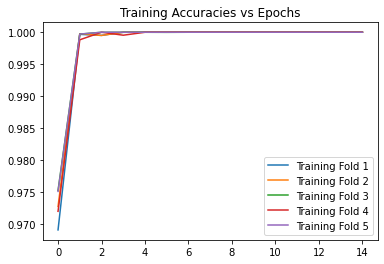

In [15]:
plt.title('Training Accuracies vs Epochs')
plt.plot(model_history[0].history['auc'], label='Training Fold 1')
plt.plot(model_history[1].history['auc'], label='Training Fold 2')
plt.plot(model_history[2].history['auc'], label='Training Fold 3')
plt.plot(model_history[3].history['auc'], label='Training Fold 4')
plt.plot(model_history[4].history['auc'], label='Training Fold 5')
plt.legend()
plt.show()

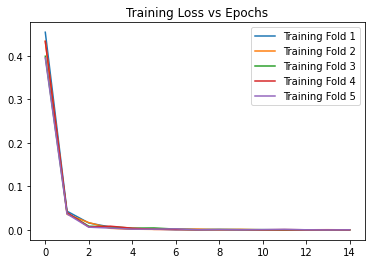

In [17]:
plt.title('Training Loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.plot(model_history[4].history['loss'], label='Training Fold 5')
plt.legend()
plt.show()

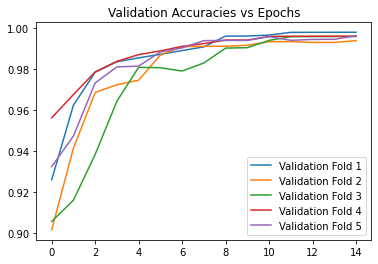

In [16]:
plt.title('Validation Accuracies vs Epochs')
plt.plot(model_history[0].history['val_auc'], label='Validation Fold 1')
plt.plot(model_history[1].history['val_auc'], label='Validation Fold 2')
plt.plot(model_history[2].history['val_auc'], label='Validation Fold 3')
plt.plot(model_history[3].history['val_auc'], label='Validation Fold 4')
plt.plot(model_history[4].history['val_auc'], label='Validation Fold 5')
plt.legend()
plt.show()

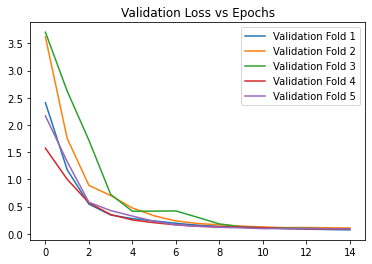

In [18]:
plt.title('Validation Loss vs Epochs')
plt.plot(model_history[0].history['val_loss'], label='Validation Fold 1')
plt.plot(model_history[1].history['val_loss'], label='Validation Fold 2')
plt.plot(model_history[2].history['val_loss'], label='Validation Fold 3')
plt.plot(model_history[3].history['val_loss'], label='Validation Fold 4')
plt.plot(model_history[4].history['val_loss'], label='Validation Fold 5')
plt.legend()
plt.show()

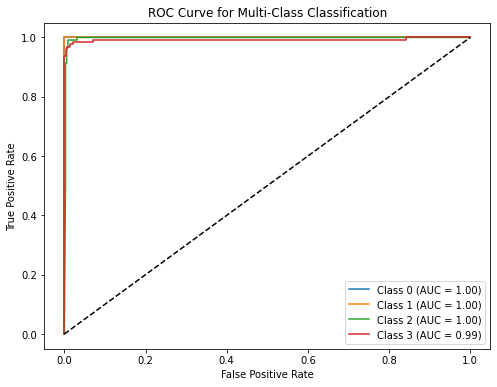

In [39]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get model predictions (probabilities)
y_pred_probs = model.predict(test_data)  # Get probabilities




In [43]:
print(test_data.shape, test_labels.shape)

(468, 150, 150, 3) (468,)


In [41]:
from tensorflow.keras.models import load_model

# Load the previously saved weights
savedModel=load_model("/kaggle/working/model_4.h5")
savedModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51200)             204800    
_________________________________________________________________
dense (Dense)                (None, 2048)              104859648 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [46]:
# Re-evaluate the model
pred_labels = savedModel.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
npa = np.asarray(test_labels, dtype=np.float32)
print(test_labels,pred_labels)
print(classification_report(npa, pred_labels))

from sklearn.metrics import roc_auc_score
print("Accuracy is",roc_auc_score(npa, pred_labels))

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]] [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       104
           2       0.98      1.00      0.99       116
           3       1.00      0.98      0.99       126

   micro avg       1.00      1.00      1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468
 samples avg       1.00      1.00      1.00       468

Accuracy is 0.9973056457431457


(468, 4)


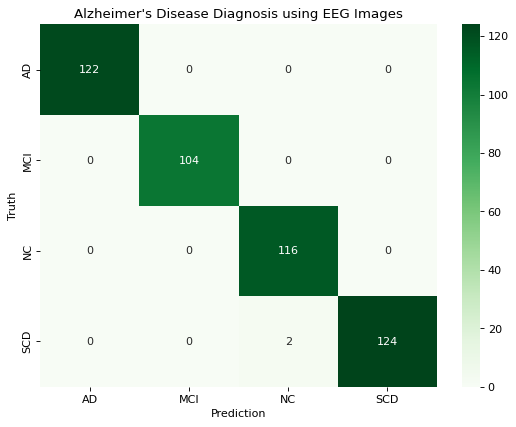

In [49]:
#Plot the confusion matrix to understand the classification in detail
import seaborn as sns
import matplotlib.pyplot as plt

pred_ls = np.argmax(pred_labels, axis=1)
print(test_labels.shape)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis using EEG Images')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

hi


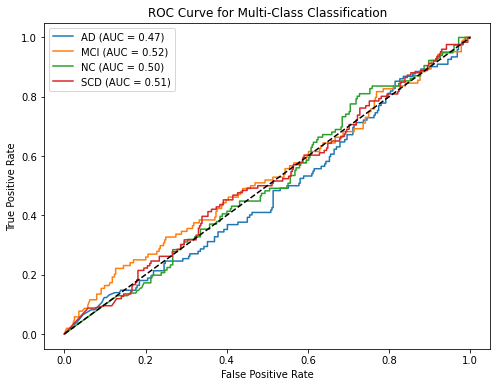

In [50]:
# Convert categorical labels to one-hot if needed
from tensorflow.keras.utils import to_categorical
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=-1)  
test_labels_one_hot = to_categorical(test_labels, num_classes=4)  # Adjust num_classes as needed

# Plot ROC Curve for Each Class
plt.figure(figsize=(8, 6))
class_names = ['AD', 'MCI', 'NC','SCD']
for i in range(4):  # Assuming 4 classes
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

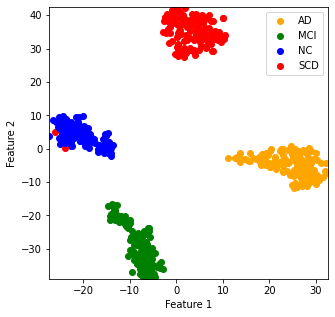

In [53]:
from keras.models import Model
from sklearn.manifold import TSNE
model_cut = Model(inputs=savedModel.inputs, outputs=savedModel.layers[-5].output)
features = model_cut.predict(test_data)
features.shape
x_final1 = TSNE().fit_transform(features)
x, y = x_final1[:, 0], x_final1[:, 1]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
ylabel = test_labels.tolist()
colors = ['orange', 'green', 'blue', 'red']
for i in range(0,len(ylabel)):
    if (ylabel[i].index(1))==0:
        lo = plt.scatter(x[i], y[i], marker='o', color=colors[0])
    if (ylabel[i].index(1))==1:
        ll = plt.scatter(x[i], y[i], marker='o', color=colors[1])
    if (ylabel[i].index(1))==2:
        l2 = plt.scatter(x[i], y[i], marker='o', color=colors[2])
    if (ylabel[i].index(1))==3:
        l3 = plt.scatter(x[i], y[i], marker='o', color=colors[3])

plt.legend((lo, ll, l2, l3),
           ('AD', 'MCI', 'NC','SCD'))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.margins(x=0)
plt.margins(y=0)
plt.show()